In [1]:
import sys,os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from IPython.display import display, Markdown
from importlib import reload

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution
#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
def getPoints(slhaFile,sigmacut=1.0,
              massCompress=True,invisibleCompress=True,
              version=3):    
    
    path = sys.path[:]
    if version == 3:
        sys.path.append('../')
        from smodels.matching.theoryPrediction import theoryPredictionsFor
    else:
        sys.path.append('/home/lessa/smodels')
        from smodels.decomposition.theoryPrediction import theoryPredictionsFor
    
    from smodels.share.models.SMparticles import SMList
    from smodels.base.model import Model
    from smodels.base.physicsUnits import fb, GeV, TeV
    from smodels.decomposition.decomposer import decompose
    from smodels.share.models.mssm import BSMList 
    
    from smodels.experiment.databaseObj import Database
    from smodels.tools import coverage
    
    
    model = Model(BSMparticles=BSMList, SMparticles=SMList)
    model.updateParticles(inputFile=slhafile)
    t0 = time.time()
    if version == 3:
        topDict = decompose(model, sigmacut= sigmacut*fb, 
                        massCompress=massCompress, 
                        invisibleCompress=invisibleCompress)
        nEl = len(topDict.getSMSList())        
        
        database = Database(os.path.expanduser('~/smodels-database'))
        listOfExpRes = database.getExpResults()
        for expResult in listOfExpRes:
            predictions = theoryPredictionsFor(expResult, topDict, combinedResults=False, marginalize=False)
        uncovered = coverage.Uncovered(topDict, sqrts=13.*TeV)
        
    else:
        topDict = decompose(model, sigmacut= sigmacut*fb, 
                        doCompress=massCompress, 
                        doInvisible=invisibleCompress)
        nEl = len(topDict.getElements())
        
        database = Database(os.path.expanduser('~/smodels-database-master'))
        listOfExpRes = database.getExpResults()
        for expResult in listOfExpRes:
            predictions = theoryPredictionsFor(expResult, topDict, combinedResults=False, marginalize=False)
        uncovered = coverage.Uncovered(topDict, sqrts=13.*TeV)
        
        
    dt = (time.time() -t0 )
    
    
    sys.path = path[:]
    
    return (nEl,dt)

In [3]:
slhafile = '../inputFiles/slha/lightEWinos.slha'
sigmacut = [30.,20.,7.,5.,1.,0.5,0.1]

### Get points for version 3

In [4]:
pts = []
for sig in sigmacut:
    pts.append(getPoints(slhafile,sigmacut=sig))

In [5]:
# Clear modules
for mod in list(sys.modules.keys()):
    if 'smodels' in mod:
        sys.modules.pop(mod)

### Get points for version 2

In [6]:
pts0 = []
for sig in sigmacut:
    pts0.append(getPoints(slhafile,sigmacut=sig,version=2))

In [7]:
pts = np.array(pts)
pts0 = np.array(pts0)

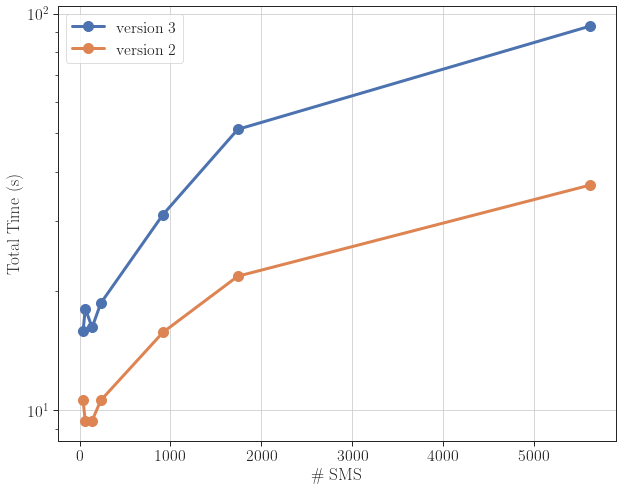

In [8]:
fig = plt.figure(figsize=(10,8))
plt.plot(pts[:,0],pts[:,1],linewidth=3,label='version 3',linestyle='-',marker='o',markersize=10)
plt.plot(pts0[:,0],pts0[:,1],linewidth=3,label='version 2',linestyle='-',marker='o',markersize=10)
plt.xlabel('\# SMS')
plt.ylabel('Total Time (s)')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

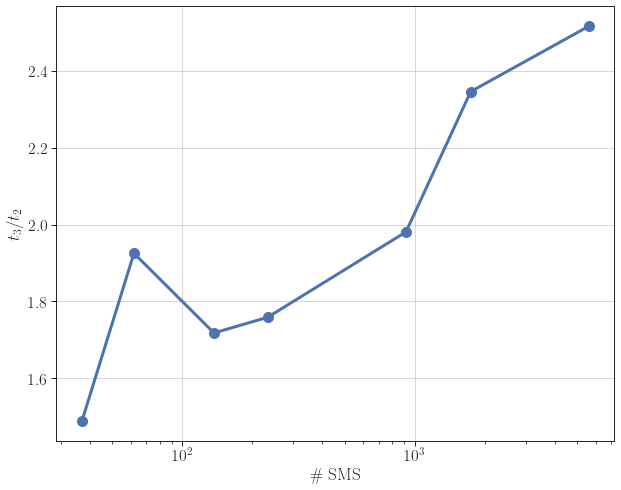

In [9]:
fig = plt.figure(figsize=(10,8))
plt.plot(pts[:,0],pts[:,1]/pts0[:,1],linewidth=3,linestyle='-',marker='o',markersize=10)
plt.xlabel('\# SMS')
plt.ylabel(r'$t_3/t_2$')
# plt.yscale('log')
plt.xscale('log')
# plt.legend()
plt.grid()
plt.show()